In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

# R3: **Single Product and Adversirial environment**

### BUYER: Users

It is a very adversarial environment

changing parameters we can make it slightly stochastic for R5

In [4]:
class Buyer:
  def __init__(self, mu=0.5, sigma=1.0, change_frequency=20, drift_rate=0.05):
    """
    Represents an adversarial buyer with non-stationary valuation distribution.
    The distribution parameters change over time to create a challenging environment.
    
    :param mu: Initial mean of the valuation distribution
    :param sigma: Initial standard deviation of the valuation distribution  
    :param change_frequency: How often (in rounds) to make abrupt changes
    :param drift_rate: Rate of gradual drift in parameters
    """

    self.initial_mu = mu
    self.initial_sigma = sigma
    self.mu = mu
    self.sigma = sigma
    self.change_frequency = change_frequency
    self.drift_rate = drift_rate
    self.round_count = 0
    self.phase = 0
    
    # Parameter ranges for random generation
    self.mu_range = (0.2, 1.0)    # Range for mean valuation
    self.sigma_range = (0.2, 1.5)  # Range for standard deviation

  def round(self, price):
    """
    Generates a valuation from the current non-stationary distribution and decides purchase.
    The distribution changes over time to create an adversarial environment.
    
    :param price: Offered price
    :return: 1 if buyer accepts (price < valuation), 0 otherwise
    """
    self.round_count += 1
    
    # Update distribution parameters based on adversarial strategy
    self._update_distribution()
    
    # Generate valuation from current distribution
    valuation = np.random.normal(self.mu, self.sigma)
    
    # Ensure valuation is non-negative (economic constraint)
    valuation = max(0, valuation)
    
    return 1 if price < valuation else 0
  
  def _update_distribution(self):
    """
    Updates the valuation distribution parameters using an adversarial strategy.
    Uses completely random parameters at each phase change to maximize unpredictability.
    Combines abrupt random changes with gradual drift to create extreme non-stationarity.
    """
    # Abrupt phase changes with completely random parameters
    if self.round_count % self.change_frequency == 0:
      self.phase += 1
      
      # Generate completely random parameters within reasonable economic bounds
      self.mu = np.random.uniform(self.mu_range[0], self.mu_range[1])
      self.sigma = np.random.uniform(self.sigma_range[0], self.sigma_range[1])
      
      """print(f"Round {self.round_count}: Random phase change #{self.phase} (μ={self.mu:.3f}, σ={self.sigma:.3f})")"""
    
    # Add gradual drift between phase changes
    else:
      # Sinusoidal drift to create smooth but unpredictable changes
      drift_factor = np.sin(self.round_count * 0.02) * self.drift_rate
      self.mu += drift_factor
      
      # Add some random walk component
      self.mu += np.random.normal(0, self.drift_rate * 0.5)
      self.sigma += np.random.normal(0, self.drift_rate * 0.2)
      
      # Ensure parameters stay within reasonable bounds
      self.mu = np.clip(self.mu, self.mu_range[0], self.mu_range[1])
      self.sigma = np.clip(self.sigma, self.sigma_range[0], self.sigma_range[1])
  
  def get_current_params(self):
    """Returns current distribution parameters for analysis."""
    return {'mu': self.mu, 'sigma': self.sigma, 'round': self.round_count, 'phase': self.phase}
  
  def get_phase_description(self):
    """Returns a description of the current phase based on parameter values."""
    if self.mu < 0.3:
      valuation_level = "Low"
    elif self.mu < 0.7:
      valuation_level = "Medium" 
    else:
      valuation_level = "High"
    
    if self.sigma < 0.5:
      variance_level = "Low variance"
    elif self.sigma < 1.0:
      variance_level = "Medium variance"
    else:
      variance_level = "High variance"
    
    return f"{valuation_level} valuation, {variance_level}"

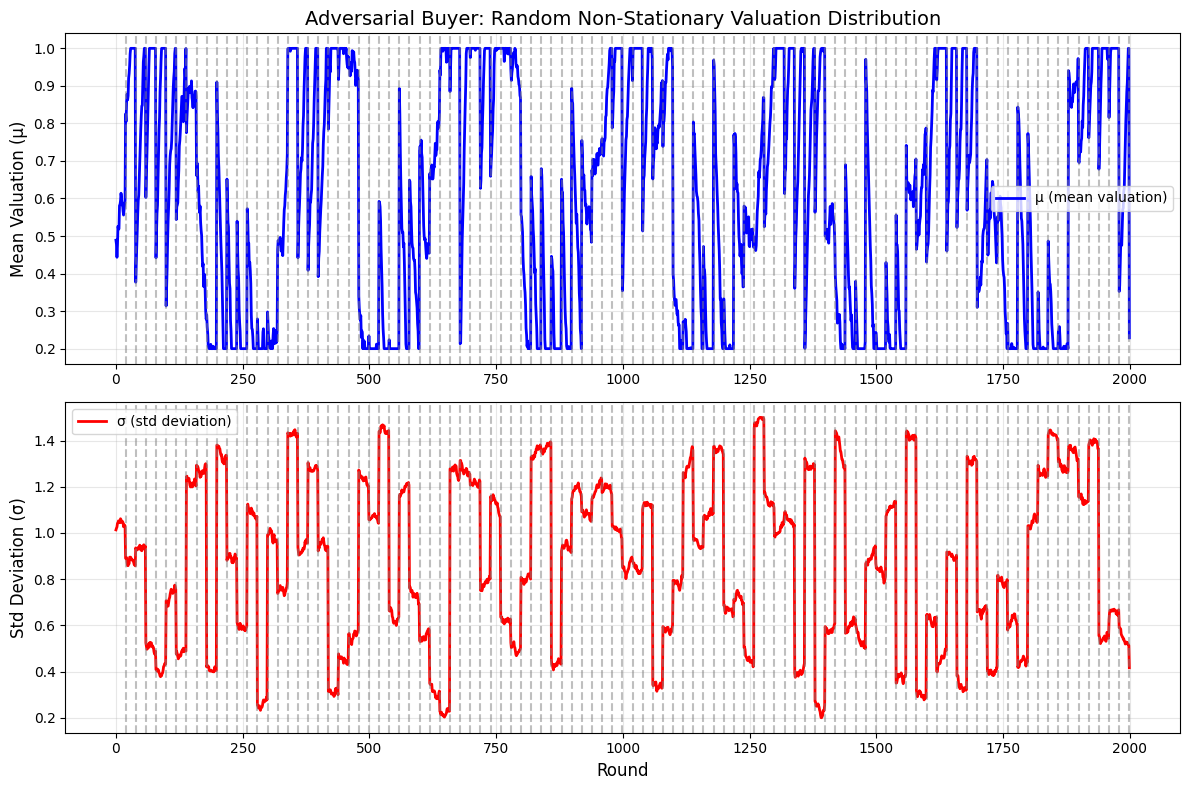

Demonstrated 100 random phase changes
Phase changes occurred at rounds: [19, 39, 59, 79, 99, 119, 139, 159, 179, 199]...
μ range: [0.200, 1.000]
σ range: [0.200, 1.500]
Example buyer behaviors encountered: ['Low valuation, Medium variance', 'Medium valuation, Low variance', 'Low valuation, High variance', 'Low valuation, Low variance', 'Medium valuation, High variance']


In [9]:
# Demonstrate the adversarial buyer's non-stationary behavior with random parameters
def visualize_adversarial_buyer(T=2000):
    """
    Visualize how the adversarial buyer's randomly changing parameters evolve over time.
    """
    buyer = Buyer()
    
    rounds = []
    mus = []
    sigmas = []
    phases = []
    phase_descriptions = []
    
    # Simulate the buyer over time to track parameter changes
    for t in range(T):
        # Just call round with a dummy price to trigger parameter updates
        buyer.round(0.5)  
        params = buyer.get_current_params()
        
        rounds.append(t)
        mus.append(params['mu'])
        sigmas.append(params['sigma'])
        phases.append(params['phase'])
        phase_descriptions.append(buyer.get_phase_description())
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot mu over time
    ax1.plot(rounds, mus, 'b-', linewidth=2, label='μ (mean valuation)')
    ax1.set_ylabel('Mean Valuation (μ)', fontsize=12)
    ax1.set_title('Adversarial Buyer: Random Non-Stationary Valuation Distribution', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot sigma over time
    ax2.plot(rounds, sigmas, 'r-', linewidth=2, label='σ (std deviation)')
    ax2.set_xlabel('Round', fontsize=12)
    ax2.set_ylabel('Std Deviation (σ)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add phase change indicators
    phase_changes = [i for i in range(1, len(phases)) if phases[i] != phases[i-1]]
    for change_point in phase_changes:
        ax1.axvline(x=change_point, color='gray', linestyle='--', alpha=0.5)
        ax2.axvline(x=change_point, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Demonstrated {len(phase_changes)} random phase changes")
    print(f"Phase changes occurred at rounds: {phase_changes[:10]}{'...' if len(phase_changes) > 10 else ''}")
    print(f"μ range: [{min(mus):.3f}, {max(mus):.3f}]")
    print(f"σ range: [{min(sigmas):.3f}, {max(sigmas):.3f}]")
    
    # Show some example phase descriptions
    unique_descriptions = list(set(phase_descriptions))
    print(f"Example buyer behaviors encountered: {unique_descriptions[:5]}")

# Run the visualization
visualize_adversarial_buyer()

### COMPANY

single ptoduct

In [5]:
class CompanyEXP3:
  def __init__(self, K, B, T):
    """
    EXP3 algorithm adapted for adversarial bandits with budget constraints.
    
    :param K: Number of arms (prices)
    :param B: Total budget
    :param T: Time horizon
    :param gamma: Exploration parameter (if None, uses theoretical optimal)
    :param eta: Learning rate (if None, uses theoretical optimal)
    """
    self.K = K
    self.T = T
    self.budget = B
    self.initial_budget = B
    self.rho = B / T  # Budget rate
    self.t = 0
    self.p_t = None
    
    self.gamma = min(1, np.sqrt(K * np.log(K) / ((np.e - 1) * T)))
    self.eta = np.sqrt(np.log(K) / (K * T))
    
    # Initialize weights and estimated rewards
    self.weights = np.ones(K)
    self.estimated_rewards = np.zeros(K)
    self.estimated_costs = np.zeros(K)
    self.probabilities = np.ones(K) / K
    
    print(f"EXP3 initialized with γ={self.gamma:.4f}, η={self.eta:.4f}")

  def pull_arm(self):
    """
    Select an arm using EXP3 with budget-aware probability distribution.
    """
    if self.budget < 1:
      self.p_t = 0  # Default to lowest price when budget exhausted
      return 0
    
    # Compute EXP3 probabilities
    # EXP3 probability update
    exp_weights = np.exp(self.eta * self.estimated_rewards)
    self.weights = exp_weights
    # Normalize to get probabilities with exploration
    sum_weights = np.sum(self.weights)
    self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + self.gamma / self.K
    
    # Budget-aware arm selection using linear programming approach
    # similar to UCB but with EXP3 probabilities as baseline
    if self.t > 0:
      gamma_budget = self._compute_budget_aware_distribution()
      self.p_t = np.random.choice(self.K, p=gamma_budget)
    else:
      self.p_t = np.random.choice(self.K, p=self.probabilities)
    
    return self.p_t


  def _compute_budget_aware_distribution(self):
    """
    Compute budget-aware probability distribution combining EXP3 with budget constraints.
    """
    # Remaining budget rate
    remaining_rounds = max(1, self.T - self.t)
    current_rho = self.budget / remaining_rounds
    
    # If we have plenty of budget, use pure EXP3
    if current_rho >= self.rho:
      return self.probabilities
    
    # Otherwise, solve constrained optimization similar to UCB approach
    # but using EXP3 probabilities as the objective
    try:
      # Objective: maximize expected utility weighted by EXP3 probabilities
      # We approximate this by using estimated rewards
      c = -self.estimated_rewards  # Negative for maximization
      
      # Budget constraint: expected cost <= current budget rate
      A_ub = [self.estimated_costs]
      b_ub = [current_rho]
      
      # Probability constraint
      A_eq = [np.ones(self.K)]
      b_eq = [1]
      
      bounds = [(0, 1)] * self.K
      
      res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                           bounds=bounds, method='highs')
      
      if res.success:
        # Blend with EXP3 probabilities for exploration
        blend_factor = 0.7  # How much to trust the LP solution
        gamma_budget = blend_factor * res.x + (1 - blend_factor) * self.probabilities
        return gamma_budget / np.sum(gamma_budget)  # Renormalize
      else:
        return self.probabilities
    except:
      # Fallback to EXP3 probabilities if optimization fails
      return self.probabilities

  def update(self, f_t, c_t):
    """
    Update the algorithm with observed reward and cost.
    
    :param f_t: Observed reward (revenue)
    :param c_t: Observed cost (units sold)
    """
    self.t += 1
    self.budget -= c_t
    
    # EXP3 importance-weighted reward estimation
    if self.probabilities[self.p_t] > 0:
      # Importance-weighted estimator
      reward_estimate = f_t / self.probabilities[self.p_t]
      cost_estimate = c_t / self.probabilities[self.p_t]
      
      # Update estimated rewards for the selected arm
      self.estimated_rewards[self.p_t] += reward_estimate
      self.estimated_costs[self.p_t] = (self.estimated_costs[self.p_t] * (self.t - 1) + cost_estimate) / self.t
    
    # Clip estimates to prevent explosion
    self.estimated_rewards = np.clip(self.estimated_rewards, -10, 10)
    self.estimated_costs = np.clip(self.estimated_costs, 0, 2)

  def get_algorithm_state(self):
    """Return current state for debugging/analysis."""
    return {
      'weights': self.weights.copy(),
      'probabilities': self.probabilities.copy(),
      'estimated_rewards': self.estimated_rewards.copy(),
      'estimated_costs': self.estimated_costs.copy(),
      'budget': self.budget,
      'round': self.t
    }

### SIMULATION


In [6]:
def best_utility_adversarial(buyer_params, agent_state):
    """
    Compute the optimal utility using randomized pricing strategy for adversarial environment.
    This represents the a posteriori optimal decision given current buyer distribution
    and agent state (remaining budget)
    
    :param buyer_params: Dictionary with current buyer parameters (mu, sigma, round, phase)
    :param agent_state: Dictionary with current agent state (budget, round, etc.)
    :return: Optimal expected utility for this round
    """
    # Extract current buyer parameters
    mu = buyer_params['mu']
    sigma = buyer_params['sigma']
    
    # Extract agent state
    remaining_budget = agent_state['budget']
    current_round = agent_state['round']
    
    # If no budget remaining, utility is 0
    if remaining_budget <= 0:
        return 0.0
    
    # Available prices (same as in simulation)
    prices = np.linspace(0, 1, 11)
    
    # Compute remaining budget rate (expected units we can afford per round)
    remaining_rounds = max(1, 10000 - current_round)  # T - current_round
    rho = remaining_budget / remaining_rounds
    
    # Ensure rho is at least small positive value to avoid infeasible problems
    rho = max(rho, 0.001)
    
    try:
        # Compute win probabilities for current buyer distribution
        win_probabilities = 1 - norm.cdf(prices, loc=mu, scale=sigma)
        
        # Objective: maximize expected revenue = sum(gamma_i * price_i * win_prob_i)
        c = -(prices * win_probabilities)  # Negate for minimization
        
        # Constraint: expected units sold ≤ rho (budget constraint)
        A_ub = [win_probabilities]
        b_ub = [rho]
        
        # Constraint: gamma is a probability distribution
        A_eq = [np.ones(len(prices))]
        b_eq = [1]
        
        bounds = [(0, 1)] * len(prices)
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                              A_eq=A_eq, b_eq=b_eq,
                              bounds=bounds, method='highs')
        
        if res.success:
            # Return the optimal expected revenue
            expected_revenue = -res.fun
            return expected_revenue
        else:
            # Fallback: use greedy approach if optimization fails
            expected_utilities = prices * win_probabilities
            return max(expected_utilities)
            
    except:
        # Fallback: simple greedy approach
        win_probabilities = 1 - norm.cdf(prices, loc=mu, scale=sigma)
        expected_utilities = prices * win_probabilities
        return max(expected_utilities)


In [7]:
T = 10000
B = 5000
P = np.linspace(0, 1, 11)
K = len(P)

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  buyer = Buyer()
  agent = CompanyEXP3(K=K, B=B, T=T)
  ag_utility = np.zeros(T)
  best_utility = np.zeros(T)
  regret = np.zeros(T)

  flag = True
  for i in range(T):
    arm = agent.pull_arm()
    price = P[arm]

    sold = buyer.round(price)

    f_t = price if sold else 0        # reward: revenue
    c_t = 1 if sold else 0            # cost: unit consumed

    agent.update(f_t=f_t, c_t=c_t)

    ag_utility[i] = f_t
    best_utility[i] = best_utility_adversarial(buyer.get_current_params(), agent.get_algorithm_state())
    regret[i] = best_utility[i] - ag_utility[i]
    #print(regret[i])

    if agent.budget <= 1 and flag:
      print("TRIAL", seed , "Budget exhausted at round", i)
      flag = False

  cumulative_regret = np.cumsum(regret)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 0 Budget exhausted at round 9194
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 1 Budget exhausted at round 9082
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 2 Budget exhausted at round 9313
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 3 Budget exhausted at round 9135
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 4 Budget exhausted at round 9402
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 5 Budget exhausted at round 9249
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 6 Budget exhausted at round 8917
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 7 Budget exhausted at round 9173
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 8 Budget exhausted at round 9258
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 9 Budget exhausted at round 9241
Agent Cumulative Reward 2059.1
Average cumulative regret 1085.2994460755194


In [8]:
P


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

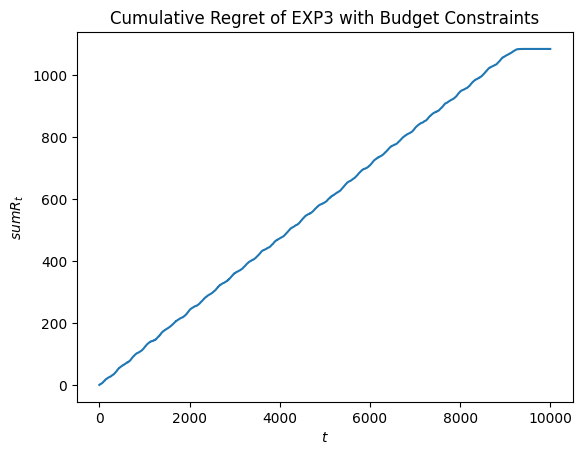

In [12]:
plt.plot(average_regret)
plt.xlabel('$t$')
plt.ylabel('$sum R_t$')
plt.title('Cumulative Regret of EXP3 with Budget Constraints')
plt.show()

Remarks
---

- SUBLINEAR PSEUDO REGRET ACHEIVED
- PSEUDO REGRET OF $O (T^{2/3}\log T)$ ACHEIVED
- PSEUDO REGRET OF $O (T^{2/3})$ ACHEIVED


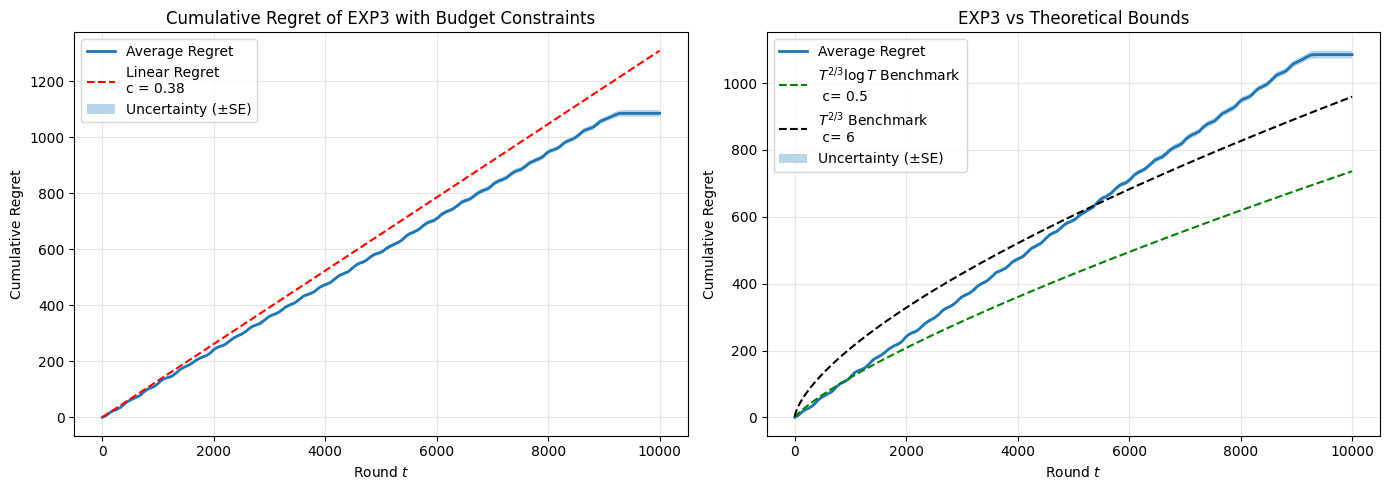

Final regret: 1085.30 ± 11.69
Expected utility estimate: 0.344
Regret growth rate: 0.1085 per round


In [20]:
# Enhanced visualization with theoretical benchmarks
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Estimate expected utility for benchmarks (use mean of best utilities)
exp_utility = np.mean(best_utility[best_utility > 0])  # Average non-zero utility

# First subplot: Cumulative regret with linear benchmark
axs[0].plot(np.arange(T), average_regret, label='Average Regret', linewidth=2)
axs[0].set_title('Cumulative Regret of EXP3 with Budget Constraints')

# Linear regret benchmark
c_linear = 0.38
linear_regret = np.arange(T) * exp_utility * c_linear
axs[0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc = {c_linear}', linestyle='--', color='red')

# Add uncertainty band
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty (±SE)'
)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Second subplot: Theoretical benchmarks for adversarial bandits
axs[1].plot(np.arange(T), average_regret, label='Average Regret', linewidth=2)
axs[1].set_title('EXP3 vs Theoretical Bounds')

t_vals = np.arange(1, T+1)

# EXP3 theoretical bound: O(sqrt(KT log K))
c_log = 0.5
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * exp_utility * c_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\n c= {c_log}', linestyle='--', color='green')

c_no_log = 6
benchmark = (t_vals ** (2/3)) * exp_utility * c_no_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\n c= {c_no_log}', linestyle='--', color='black')

# Add uncertainty band
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty (±SE)'
)

axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Regret')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final regret: {average_regret[-1]:.2f} ± {regret_std[-1]/np.sqrt(n_trials):.2f}")
print(f"Expected utility estimate: {exp_utility:.3f}")
print(f"Regret growth rate: {average_regret[-1]/T:.4f} per round")